# Exploratory Analysis

**Sample Scenario**

We would like to be able to use attributes of customers to estimate their spending score.
In doing so, we can target those customers that are likely to be most profitable.

Our target variable is spending_score.
Currently the only customer data we have available to use in this project is age, annual_income and gender.
It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

## Wrangle Data 

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_excs as wrangle

In [3]:
df = wrangle.get_mall_customers('SELECT * FROM customers')
train, validate, test = wrangle.train_validate_test_split(df)

In [4]:
df = train

NB. We'll explore unscaled, but scale before modeling.

## Answer Questions

### What is the distribution of each of the variables?

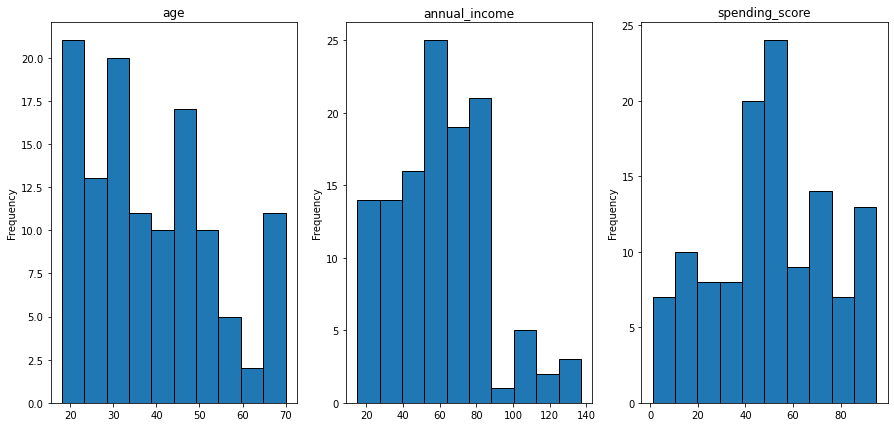

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

**Takeaways:**

### Does spending score differ across gender?

1. Viz gender against spending score
1. Stats test to confirm

Text(0.5, 1.0, 'Is there a difference in spending score for\nmale vs. female customers?')

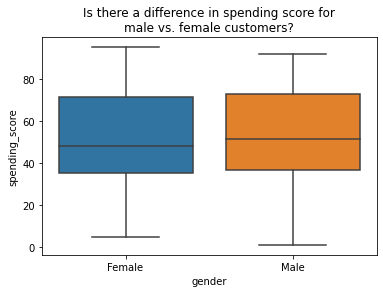

In [6]:
sns.boxplot(data=df, y='spending_score', x='gender')
plt.title("Is there a difference in spending score for\nmale vs. female customers?")

**Takeaways:**

Seems like there's not much difference in spending score. 

T-test:
    - one-tailed or two-tailed? 2 tailed b/c we are looking for any difference in means. 
    - one-sample or two-sample? 2 sample b/c we're looking at the average spending score of 2 seperate samples
    
**Levene's Test: test for equal variance

- H0: There is no difference in spending score variance between the two samples
- Ha: There is a difference in spending variance score between the two samples

T-test

**Levene's Test**: test for equal variance

In [7]:
stats.levene(
    df.query('gender == "Male"').spending_score,
    df.query('gender == "Female"').spending_score,
)

LeveneResult(statistic=0.10928566487557842, pvalue=0.7415451203905439)

In [8]:
stats.ttest_ind(
    df.query('gender == "Male"').spending_score,
    df.query('gender == "Female"').spending_score,
    equal_var=True,
)

Ttest_indResult(statistic=0.24250945188004078, pvalue=0.8088064406384925)

In [ ]:
We conclude there is no significant difference in spending score between Males and Females (p=.809)

**Conclusion:**

### Is there a relationship between spending score and annual income?

1. Viz annual_income by spending_score
2. Spearman's test if we want to confirm correlation (pearson's assumes normally distributed vars)

<AxesSubplot:title={'center':'Is there a relationship\nbetween annual income and spending score?'}, xlabel='annual_income', ylabel='spending_score'>

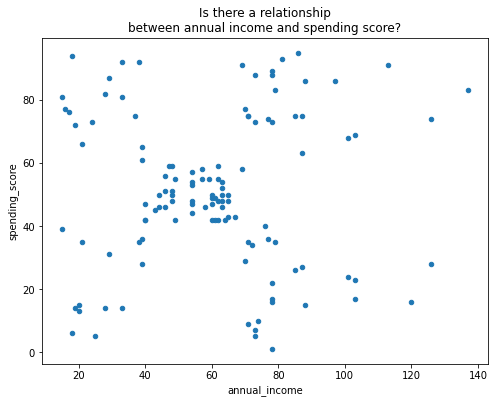

In [8]:
df.plot.scatter(
    x="annual_income",
    y="spending_score",
    title='Is there a relationship\nbetween annual income and spending score?',
    figsize=(8, 6),
)

**Conclusion:**

Is there a relationship between age and spending score?

1. Viz age by spending_score. 
1. Create age bins and compare

<AxesSubplot:title={'center':'Is there a relationship between age and spending score?'}, xlabel='age', ylabel='spending_score'>

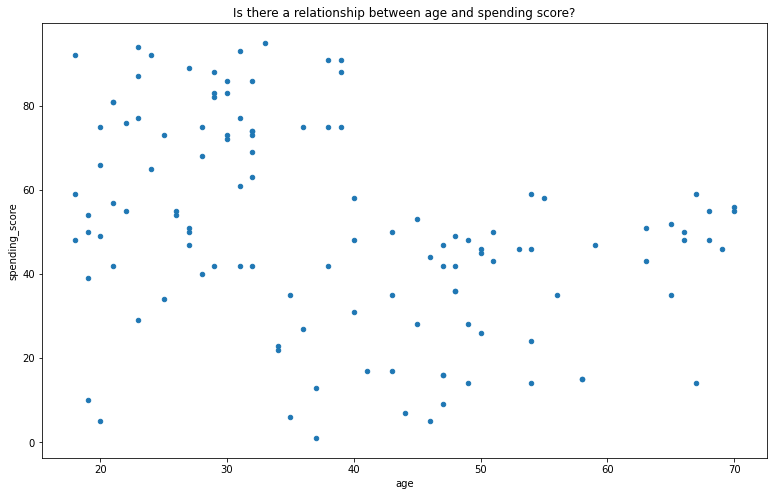

In [9]:
df.plot.scatter(y='spending_score', x='age', title='Is there a relationship between age and spending score?', figsize=(13, 8))

In [10]:
df['age_bin'] = pd.cut(df.age, [0, 40, 80])
df.head()

,gender,age,annual_income,spending_score,age_bin
customer_id,,,,,
64,Female,54,47,59,"(40, 80]"
49,Female,29,40,42,"(0, 40]"
25,Female,54,28,14,"(40, 80]"
137,Female,44,73,7,"(40, 80]"
177,Male,58,88,15,"(40, 80]"


<AxesSubplot:xlabel='age_bin', ylabel='spending_score'>

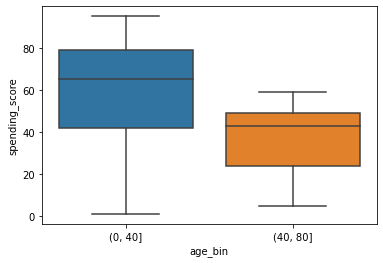

In [11]:
sns.boxplot(data=df, y='spending_score', x='age_bin')

In [12]:
stats.levene(
    df[df.age <= 40].spending_score,
    df[df.age > 40].spending_score,
)

LeveneResult(statistic=9.154464052447656, pvalue=0.0030460560375097914)

**Conclusion:**

In [13]:
stats.ttest_ind(
    df[df.age <= 40].spending_score,
    df[df.age > 40].spending_score,
    equal_var=False,
)

Ttest_indResult(statistic=6.2431568169013785, pvalue=7.026347337563538e-09)

**Conclusion:**

### If we control for age, does spending score differ across annual income?

1. Viz annual income by spending score for each age bin
2. Analyze each age bin separately

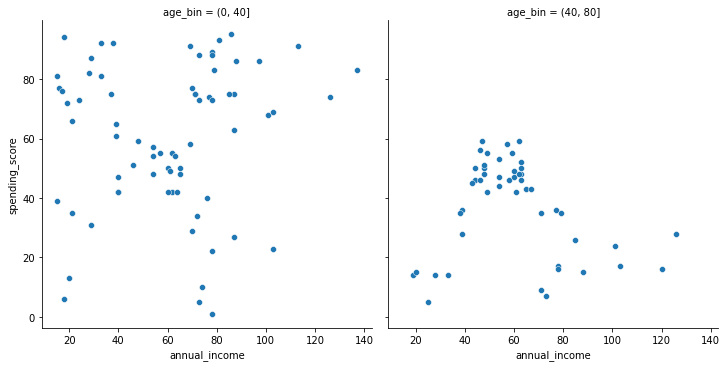

In [14]:
sns.relplot(data=df, y='spending_score', x='annual_income', col='age_bin')

**Takeaways:**

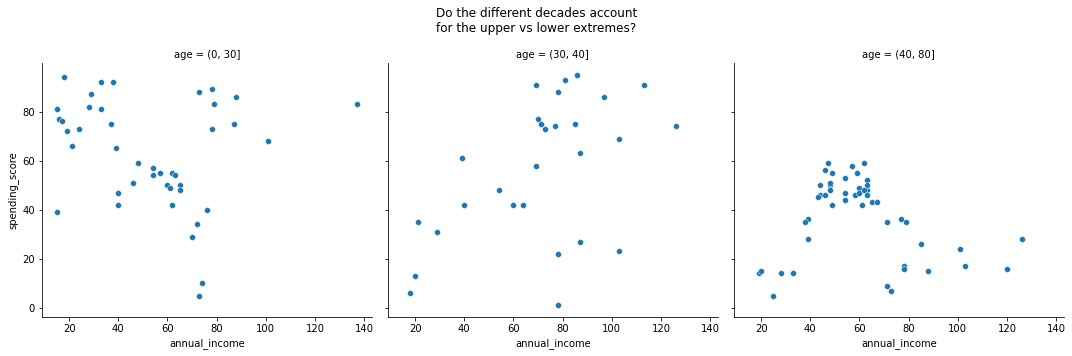

In [15]:
sns.relplot(
    data=df,
    y='spending_score',
    x='annual_income',
    col=pd.cut(df.age, bins=[0, 30, 40, 80]),
)
plt.suptitle("Do the different decades account\nfor the upper vs lower extremes?")
plt.tight_layout()

**Takeaways:**

### Does gender explain the high income-low spending score and/or low income-low spending score in the under 40 group?

Text(0.5, 1.0, 'Does gender acccount for upper vs lower\nin the younger age group?')

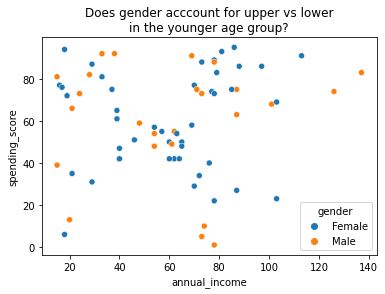

In [16]:
sns.scatterplot(
    x='annual_income',
    y='spending_score',
    data=df[df.age <= 40],
    hue='gender',
)
plt.title("Does gender acccount for upper vs lower\nin the younger age group?")

**Takeaways:**

### If we control for annual income, does spending score differ across age?

Because of the shape of annual income with spending score, I will create 3 bins of income: \[0, 40), \[40, 70), \[70, 140\]. 

In [17]:
df['income_bin'] = pd.cut(df.annual_income, [0, 40, 70, 140])

In [18]:
df.head()

,gender,age,annual_income,spending_score,age_bin,income_bin
customer_id,,,,,,
64,Female,54,47,59,"(40, 80]","(40, 70]"
49,Female,29,40,42,"(0, 40]","(0, 40]"
25,Female,54,28,14,"(40, 80]","(0, 40]"
137,Female,44,73,7,"(40, 80]","(70, 140]"
177,Male,58,88,15,"(40, 80]","(70, 140]"


Text(0.5, 1.0, 'How does age compare to spending score\nwithin each income bin?')

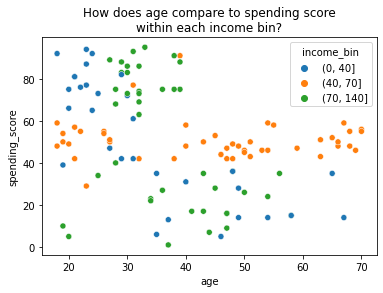

In [19]:
sns.scatterplot(
    x='age',
    y='spending_score',
    data=df,
    hue='income_bin',
)
plt.title("How does age compare to spending score\nwithin each income bin?")

**Takeaways:**

## Summary